In [26]:
# Homework 6 (due 08/08/2024)
# Abby Irish

# Neural networks and computer vision

### Objective
In this week's project, you will learn to train, validate, and test a neural network. You will explore how inputs change through feature extraction in convolutional neural networks (CNNs), and you will interpret the trained filters by the network.

#### Dataset

You will use the MNIST dataset, a standard dataset of handwritten digits, which is widely used for training and testing image processing systems.

#### Instructions

The code example below demonstrates how to define, train, validate, and test a CNN. The training and test accuracy after each completed epoch are shown after a completed

**1. Explore a working example**
1. Open `example.ipynb` and read the code.
2. Consult the pytorch documentation to learn what the arguments of the various employed pytorch functions mean.
3. Run the code.
4. Replace SGD with Adam in the training process. Then run the code again.
5. Save the output figures that show training and validation accuracy as a function of the number of epochs in your file system.

**2. Build a network**
Create your own working example. (You are allowed to copy any amount of code from `example.ipynb`.) Your CNN should be different from the CNN in the working example in the following ways:
1. The new CNN should have three convolutional layers instead of two. The first layer creates 32 channels. The second layer creates 64 channels, and the third layer creates 128 channels.
2. The pooling layer after the third layer should not employ any padding.
3. The last hidden layer should have 512 neurons.
4. For all layers except the output layer, the activation function should be a ReLU (use `torch.nn.ReLU`).

**3. Train and evaluate a neural network**
1. Train the neural network that you have constructed in the previous step. How have the upgrades with respect to the CNN in `example.ipynb` affected the CNN's training time?
2. Test the neural network. How have the upgrades with respect to the CNN in `example.ipynb` affected the CNN's validation accuracy?
3. Identify the number $k$ of training epochs that gives you a good tradeoff between training time and validation accuracy.
4. Run your code again using $k$ epochs during training. Time the training (e.g. using the python library `time`).

**4. Model validation and model selection**
1. Use the validation set approach to identify the best number $c$ of channels in the first convolutional layer (consider $c\in\{2,15\}$).
2. Update your neural network architecture so that the first convolutional layer has $c$ channels.

**5. Visualizing feature extraction**
1. Use the function `plot_mapped_features` to view an input image and the corresponding first channel of the hidden state for each feature-extraction layer (i.e., each convolution layer and each pooling layer).
2. Update the function so that it shows all channels instead of just one.
3. Comment on where you observe differences between the channels within a layer.

**6. Visualizing and interpreting filters**
1. Use the function `plot_filters` to view the trained filters of the first convolutional layer.
2. Identify the filters that perform blurring, sharpening, or horizontal or vertical edge detection.

**7. Comparison to logistic regression**
1. Construct and run a pipeline for multiclass logistic regression of the MNIST dataset using sklearn.
2. Comment on how the training time and test accuracy of logistic regression compare to the CNN.
3. Now run multiclass logistic regression on the MNIST data set using one of the hidden states of the CNN (i.e., $\vec{x}^{(2)}$, $\vec{x}^{(3)}$, ..., $\vec{x}^{(7)}$) as inputs. Which set of inputs yields the best classification results?

In [44]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import time

## Part 2: Build a neural network

In [29]:
# Load and preprocess the MNIST dataset

# Define an array transformation that transforms the images to tensor format 
# and normalizes the pixel values to the range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training and test datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, 
    download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, 
    download=True, transform=transform)

# Split the training dataset into a training set and a validation set
train_set, val_set = random_split(train_dataset, [50000, 10000])

# Create data loaders for the training, validation, and test sets
# A DataLoader in PyTorch is an object that simplifies and automates
# batching, shuffling, and loading data for model training and evaluation. 
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [33]:
# **2. Build a network**

# Create your own working example. (You are allowed to copy any amount of code from `example.ipynb`.) 
    #  Your CNN should be different from the CNN in the working example in the following ways:
# 1. The new CNN should have three convolutional layers instead of two. The first layer creates 32 channels. 
    # The second layer creates 64 channels, and the third layer creates 128 channels.
# 2. The pooling layer after the third layer should not employ any padding.
# 3. The last hidden layer should have 512 neurons.
# 4. For all layers except the output layer, the activation function should be a ReLU (use `torch.nn.ReLU`).

# Define CNN architecture

class CNN(nn.Module):
    """
    A Convolutional Neural Network (CNN) for classifying MNIST images.
    
    The network consists of a feature extraction architecture and a 
    classification architecture. The feature-extraction architecture includes
    two convolutional layers. Each of the convolutional layers is followed by 
    a sigmoid activation and a max pooling layer. The classification 
    architecture includes two fully connected layers for classification.

    Attributes:
    conv1 : torch.nn.Conv2d
        The first convolutional layer
    conv2 : torch.nn.Conv2d
        The second convolutional layer
    conv3: torch.nn.Conv2d
        The third convolutional layer
    activation : torch.nn activation function
        Activation function used for input and hidden layers
    pool : torch.nn.MaxPool2d
        The pooling layer
    fc1 : torch.nn.Linear
        The first fully connected layer
    fc2 : torch.nn.Linear
        The second fully connected layer

    Methods:
    __init__(self): 
        This function creates an instance of this class.
    forward(self, x):
        Performs a forward pass for an input x.
    """

    def __init__(self):
        """
        Initialize the CNN model by defining its layers.
        """
        # Create an instance of the parent class `nn.Module`
        super(CNN, self).__init__()
        
        # Define the first convolutional layer. It uses a 32 filters of size 
        # 3-by-3 to turn a 1-channel image into an 32-channel image.         
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        
        # Define the second convolutional layer. It uses 64 filters of size 
        # 3-by-3 to turn a 32-channel image into an 16-channel image.
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Define the third convolutional layer. It uses 128 filters of size 
        # 3-by-3 to turn a 68-channel image into an 128-channel image.
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Define the activation function
        self.activation = nn.ReLU()

        # Define a pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define a fully connected layer hidden with 512 nodes
        # Inputs are num_channels in previous layer x image height x image width
        self.fc1 = nn.Linear(128 * 3 * 3, 512)

        # Define the output layer with 10 nodes
        self.fc2 = nn.Linear(512, 10)
        
        
    def forward(self, x):
        """
        Define the forward pass of the CNN.

        Parameters:
        x : torch.Tensor
            The input tensor containing the image batch.

        Returns:
        torch.Tensor
            The output tensor containing the class scores for each image.
        """
        # Pass the input through each convolutional layer, applying activation after each one
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)     
        x = self.activation(self.conv3(x))
        x = self.pool(x)  

        # Change the shape of x into a 1d array
        x = x.view(-1, 128 * 3 * 3)

        # Pass the input through the full connected hidden layer, then apply activation
        x = self.activation(self.fc1(x))
        # Pass the input through the last layer
        x = self.fc2(x)
        
        return x

## Part 3: Train and test the neural network

1. Train the neural network that you have constructed in the previous step. 

In [34]:
# Define training pipeline including validation after each epoch

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    """
    Train the CNN model.

    Parameters:
    model : torch.nn.Module
        The CNN model to be trained.
    train_loader : torch.utils.data.DataLoader
        The data loader for the training set.
    val_loader : torch.utils.data.DataLoader
        The data loader for the validation set.
    criterion : torch.nn.modules.loss._Loss
        The loss function to be used.
    optimizer : torch.optim.Optimizer
        The optimizer to be used.
    epochs : int
        The number of epochs for training.

    Returns:
    tuple
        A tuple containing lists of training loss, validation loss, training accuracy, and validation accuracy.
    """
    # Initialize lists to store training and validation loss
    train_loss, val_loss = [], []
    # Initialize lists to store training and validation and accuracy
    train_acc, val_acc = [], []

    # Loop over the number of epochs
    for epoch in range(epochs):
        # Set the model to training mode
        model.train()  
        # Initialize the running loss for the epoch
        running_loss = 0.0  
        # Initialize counters for correct predictions and total samples
        correct, total = 0, 0  

        # Learning algorithm is SGD with minibatch. Iterating over the dataload
        # returns images and labels in batches.
        
        # Iterate over batches of training data
        for images, labels in train_loader:
            # Zero the gradients to prevent accumulation from previous iterations
            optimizer.zero_grad()  
            # Perform a forward pass through the model to get predictions
            outputs = model(images)  
            # Compute the loss between predictions and true labels
            loss = criterion(outputs, labels)  
            # Perform a backward pass to compute gradients via backpropagation
            loss.backward()  
            # Update model parameters based on the computed gradients
            optimizer.step()  

            # Add up the loss
            running_loss += loss.item()  
            # Get the predicted class with the highest score
            _, predicted = torch.max(outputs.data, 1)  
            # Update the total number of samples
            total += labels.size(0)  
            # Update the number of correct predictions
            correct += (predicted == labels).sum().item()  

        # Compute and store the average training loss for the epoch
        train_loss.append(running_loss / len(train_loader))  
        # Compute and store the training accuracy for the epoch
        train_acc.append(100 * correct / total)  

        # Set the model to evaluation mode
        model.eval()  
        # Initialize the running loss for validation
        val_running_loss = 0.0  
        #  Initialize counters for correct predictions and total samples in validation
        val_correct, val_total = 0, 0  
        
        # Disable gradient calculation for validation to save memory and computation
        with torch.no_grad():
            # Iterate over batches of validation data
            for images, labels in val_loader:
                # Perform a forward pass through the model to get predictions
                outputs = model(images)  
                # Compute the loss between predictions and true labels
                loss = criterion(outputs, labels)  
                # Add up the loss
                val_running_loss += loss.item()  
                # Get the predicted class with the highest score
                _, predicted = torch.max(outputs.data, 1)  
                # Update the total number of samples in validation
                val_total += labels.size(0)  
                # Update the number of correct predictions in validation
                val_correct += (predicted == labels).sum().item()  

        # Compute and store the average validation loss for the epoch
        val_loss.append(val_running_loss / len(val_loader))
        # Compute and store the validation accuracy for the epoch
        val_acc.append(100 * val_correct / val_total)  
        
        # Print the results for the current epoch, including training and validation loss and accuracy
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss / len(train_loader):.4f}, '
              f'Validation Loss: {val_running_loss / len(val_loader):.4f}, '
              f'Train Acc: {100 * correct / total:.2f}%, Val Acc: {100 * val_correct / val_total:.2f}%')
        
    # Return the lists of training and validation loss and accuracy
    return train_loss, val_loss, train_acc, val_acc  

Epoch [1/10], Train Loss: 0.2015, Validation Loss: 0.0511, Train Acc: 93.71%, Val Acc: 98.42%
Epoch [2/10], Train Loss: 0.0479, Validation Loss: 0.0444, Train Acc: 98.51%, Val Acc: 98.65%
Epoch [3/10], Train Loss: 0.0323, Validation Loss: 0.0382, Train Acc: 98.98%, Val Acc: 98.84%
Epoch [4/10], Train Loss: 0.0238, Validation Loss: 0.0422, Train Acc: 99.23%, Val Acc: 98.83%
Epoch [5/10], Train Loss: 0.0181, Validation Loss: 0.0284, Train Acc: 99.39%, Val Acc: 99.23%
Epoch [6/10], Train Loss: 0.0165, Validation Loss: 0.0378, Train Acc: 99.48%, Val Acc: 98.92%
Epoch [7/10], Train Loss: 0.0137, Validation Loss: 0.0473, Train Acc: 99.58%, Val Acc: 98.69%
Epoch [8/10], Train Loss: 0.0113, Validation Loss: 0.0394, Train Acc: 99.64%, Val Acc: 99.18%
Epoch [9/10], Train Loss: 0.0115, Validation Loss: 0.0345, Train Acc: 99.60%, Val Acc: 99.19%
Epoch [10/10], Train Loss: 0.0089, Validation Loss: 0.0467, Train Acc: 99.69%, Val Acc: 98.99%


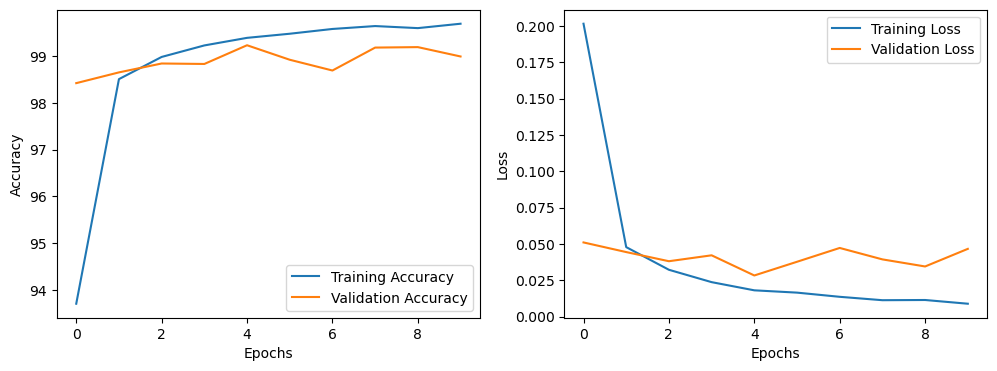

In [42]:
# Create model
model = CNN()

# Set loss function
criterion = nn.CrossEntropyLoss()

# Set training algorithm
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer)

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

How have the upgrades with respect to the CNN in `example.ipynb` affected the CNN's training time?
They have greatly increased the CNN's training time. It took 12m 7.0s to run through 10 epochs, while in the example it took only 3m 25.0s.

2. Test the neural network. 

In [45]:
# Evaluate the model on test set

model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f'Test Accuracy: {test_acc}%')

Test Accuracy: 99.0%


How have the upgrades with respect to the CNN in `example.ipynb` affected the CNN's validation accuracy?
The upgrades have increased the CNN's validation accuracy compared to the example one.

3. Identify the number $k$ of training epochs that gives you a good tradeoff between training time and validation accuracy.
4. Run your code again using $k$ epochs during training. Time the training (e.g. using the python library `time`).

In [46]:
# based on the plot above, the best value of k to get a good tradeoff is 5, 
# because after this number the validation accuracy starts to decrease again.
k = 5

# run code again and time the training:
start_time = time.time()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=k)
end_time = time.time()

training_duration = end_time - start_time

print(f'Training completed in {training_duration} seconds for {k} epochs')
print(f'Final Validation Accuracy: {val_acc[-1]}%')

Epoch [1/5], Train Loss: 0.0092, Validation Loss: 0.0504, Train Acc: 99.68%, Val Acc: 98.79%
Epoch [2/5], Train Loss: 0.0082, Validation Loss: 0.0381, Train Acc: 99.70%, Val Acc: 99.17%
Epoch [3/5], Train Loss: 0.0077, Validation Loss: 0.0544, Train Acc: 99.76%, Val Acc: 98.85%
Epoch [4/5], Train Loss: 0.0063, Validation Loss: 0.0442, Train Acc: 99.77%, Val Acc: 99.11%
Epoch [5/5], Train Loss: 0.0083, Validation Loss: 0.0549, Train Acc: 99.75%, Val Acc: 98.75%
Training completed in 349.8638241291046 seconds for 5 epochs
Final Validation Accuracy: 98.75%


## Part 4: Model validation and model selection
1. Use the validation set approach to identify the best number $c$ of channels in the first convolutional layer (consider $c\in\{2,15\}$).

In [61]:
# Define the function to train and validate the model for a given number of channels
class CNN(nn.Module):

    def __init__(self, c):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, c, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(c, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)     
        x = self.activation(self.conv3(x))
        x = self.pool(x)  

        # Change the shape of x into a 1d array
        x = x.view(-1, 128 * 3 * 3)

        # Pass the input through the full connected hidden layer, then apply activation
        x = self.activation(self.fc1(x))
        # Pass the input through the last layer
        x = self.fc2(x)
        
        return x
        
def validate_model_for_channels(c, train_loader, val_loader, criterion, optimizer, epochs=10):
    model = CNN(c)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)
    return val_acc[-1]  # Return the validation accuracy of the last epoch

# Initialize the range of c values and an empty list to store validation accuracies
c_values = range(2, 16)
val_accuracies = []

# Criterion and optimizer can be reused across different c values
criterion = nn.CrossEntropyLoss()

# Loop over different c values and evaluate the model
for c in c_values:
    val_accuracy = validate_model_for_channels(c, train_loader, val_loader, criterion, optimizer, epochs=2)
    val_accuracies.append((c, val_accuracy))
    print(f'Channels: {c}, Validation Accuracy: {val_accuracy}%')

# Find the best c value
best_c, best_val_acc = max(val_accuracies, key=lambda x: x[1])
print(f'Best number of channels in the first convolutional layer: {best_c} with Validation Accuracy: {best_val_acc:.2f}%')

Epoch [1/2], Train Loss: 0.3540, Validation Loss: 0.1141, Train Acc: 88.71%, Val Acc: 96.35%
Epoch [2/2], Train Loss: 0.0864, Validation Loss: 0.0712, Train Acc: 97.29%, Val Acc: 97.86%
Channels: 2, Validation Accuracy: 97.86%
Epoch [1/2], Train Loss: 0.3151, Validation Loss: 0.0864, Train Acc: 90.13%, Val Acc: 97.30%
Epoch [2/2], Train Loss: 0.0755, Validation Loss: 0.0612, Train Acc: 97.63%, Val Acc: 98.02%
Channels: 3, Validation Accuracy: 98.02%
Epoch [1/2], Train Loss: 0.2846, Validation Loss: 0.0789, Train Acc: 91.25%, Val Acc: 97.54%
Epoch [2/2], Train Loss: 0.0628, Validation Loss: 0.0551, Train Acc: 98.06%, Val Acc: 98.32%
Channels: 4, Validation Accuracy: 98.32%
Epoch [1/2], Train Loss: 0.2456, Validation Loss: 0.0634, Train Acc: 92.65%, Val Acc: 97.94%
Epoch [2/2], Train Loss: 0.0600, Validation Loss: 0.0526, Train Acc: 98.04%, Val Acc: 98.29%
Channels: 5, Validation Accuracy: 98.29%
Epoch [1/2], Train Loss: 0.2560, Validation Loss: 0.0735, Train Acc: 92.02%, Val Acc: 97.71%

KeyboardInterrupt: 

2. Update your neural network architecture so that the first convolutional layer has $c$ channels.

In [ ]:
# Update the CNN architecture with the best number of channels c

class UpdatedCNN(nn.Module):
    def __init__(self):
        super(UpdatedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, best_c, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(best_c, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        x = self.activation(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

## Part 5: Visualizing feature extraction**
1. Use the function `plot_mapped_features` to view an input image and the corresponding first channel of the hidden state for each feature-extraction layer (i.e., each convolution layer and each pooling layer).
2. Update the function so that it shows all channels instead of just one.
3. Comment on where you observe differences between the channels within a layer.

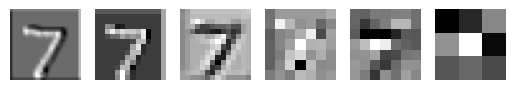

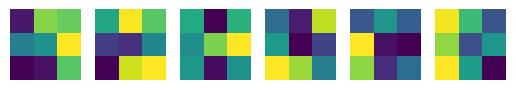

In [41]:
# Function to visualize the feature maps produced by different layers for a given image
def plot_mapped_features(model, image, layers):
    '''Example usage: 
    
    >>> examples = iter(test_loader)
    >>> example_data, example_labels = next(examples) # get one batch from test set
    >>> example_image = example_data[0]
    >>> layers = [model.conv1, model.pool, model.conv2, model.pool]
    >>> plot_mapped_features(model, example_image, layers)
    
    '''
    # Add a batch dimension to the image tensor (from (channels, height, width) to (1, channels, height, width))
    x = image.unsqueeze(0)
    # Create a subplot with 1 row and len(layers) columns
    fig, axes = plt.subplots(1, len(layers))
    # Iterate over the specified layers
    for i, layer in enumerate(layers):
        # Pass the image through the current layer
        x = layer(x)
        # Detach the feature map from the computation graph and move it to CPU, then convert it to a NumPy array
        # Visualize the first channel of the feature map
        axes[i].imshow(x[0, 0].detach().cpu().numpy(), cmap='gray')
        # Turn off the axis for a cleaner look
        axes[i].axis('off')
    # Display the feature maps
    plt.show()
    

examples = iter(test_loader)
example_data, example_labels = next(examples) # get one batch from test set
example_image = example_data[0]
layers = [model.conv1, model.pool, model.conv2, model.pool, model.conv3, model.pool]
plot_mapped_features(model, example_image, layers)

## Part 6: Visualizing and interpreting filters
1. Use the function `plot_filters` to view the trained filters of the first convolutional layer.
2. Identify the filters that perform blurring, sharpening, or horizontal or vertical edge detection.

In [ ]:
# Function to visualize the filters of a given convolutional layer
def plot_filters(layer, n_filters=6):
    '''Example usage: 

    >>> layer = model.conv1
    >>> plot_filters(layer, n_filters=6)
    
    '''
    # Clone the weights of the convolutional layer to avoid modifying the original weights
    filters = layer.weight.data.clone()
    # Normalize the filter values to the range [0, 1] for better visualization
    filters = filters - filters.min()
    filters = filters / filters.max()
    # Select the first n_filters to visualize
    filters = filters[:n_filters]
    # Create a subplot with 1 row and n_filters columns
    fig, axes = plt.subplots(1, n_filters)
    # Iterate over the selected filters
    for i, filter in enumerate(filters):
        # Transpose the filter dimensions to (height, width, channels) for visualization
        axes[i].imshow(np.transpose(filter, (1, 2, 0)))
        # Turn off the axis for a cleaner look
        axes[i].axis('off')
    # Display the filters
    plt.show()

layer = model.conv1
plot_filters(layer, n_filters=6)